In [1]:
from deepface import DeepFace
import deepface
from deepface.detectors import FaceDetector, OpenCvWrapper, SsdWrapper, DlibWrapper, MtcnnWrapper, RetinaFaceWrapper, MediapipeWrapper
import cv2
import time
from matplotlib import pyplot as plt

In [2]:
def print_image(img, title='result', covert_colors=True):
    copy_img = img.copy()
    if covert_colors:
        copy_img = cv2.cvtColor(copy_img, cv2.COLOR_BGRA2RGBA)
    plt.imshow(copy_img[:, :])
    plt.title(title)
    plt.show()


def draw_face_rectangle(img, rectangle):
    x = rectangle[0]
    y = rectangle[1]
    w = rectangle[2]
    h = rectangle[3]
    img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return img


def print_facec_with_rects(img, rects):
    cimg = img.copy()
    for rect in rects:
        draw_face_rectangle(cimg, rect)
    print_image(cimg)

def runDetector(detectorName, detector):
    startTime = time.time()

    rects = detector(img)

    resultTimeMs = (time.time() - startTime) * 1000

    print(f'--> {detectorName}')
    print(f'Execution time: {resultTimeMs} ms')
    print(rects)
    print(len(rects))
    print_facec_with_rects(img, rects)

In [3]:
 models = {
    'opencv',
    'ssd',
    'dlib',
    'mtcnn',
    'retinaface',
    'mediapipe'
}


# backends = {
#     'opencv': OpenCvWrapper.detect_face,
#     'ssd': SsdWrapper.detect_face,
#     'dlib': DlibWrapper.detect_face,
#     'mtcnn': MtcnnWrapper.detect_face,
#     'retinaface': RetinaFaceWrapper.detect_face,
#     'mediapipe': MediapipeWrapper.detect_face
# }

def detectFaceOpenCv(img):
    detector = FaceDetector.build_model('opencv')
    resp = []

    faces = detector["face_detector"].detectMultiScale(img, 1.1, 10)

    if len(faces) > 0:

        for x, y, w, h in faces:
            img_region = [x, y, w, h]
            resp.append(img_region)

    return resp

def detectFaceMtcnn(img):
    detector = FaceDetector.build_model('mtcnn')
    resp = []
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #mtcnn expects RGB but OpenCV read BGR

    detections = detector.detect_faces(img_rgb)

    if len(detections) > 0:

        for detection in detections:
            x, y, w, h = detection["box"]
            img_region = [x, y, w, h]
            resp.append(img_region)

    return resp

def detectFaceRetinaFace(img):
    from retinaface import RetinaFace

    detector = FaceDetector.build_model('retinaface')
    resp = []

    obj = RetinaFace.detect_faces(img, model = detector, threshold = 0.9)

    if type(obj) == dict:
        for key in obj:
            identity = obj[key]
            facial_area = identity["facial_area"]

            y = facial_area[1]
            h = facial_area[3] - y
            x = facial_area[0]
            w = facial_area[2] - x
            img_region = [x, y, w, h]

            resp.append(img_region)

    return resp

def detectFaceSsd(img):
    detector = FaceDetector.build_model('ssd')
    resp = []

    ssd_labels = ["img_id", "is_face", "confidence", "left", "top", "right", "bottom"]

    target_size = (300, 300)

    base_img = img.copy()  #we will restore base_img to img later

    original_size = img.shape

    img = cv2.resize(img, target_size)

    aspect_ratio_x = (original_size[1] / target_size[1])
    aspect_ratio_y = (original_size[0] / target_size[0])

    imageBlob = cv2.dnn.blobFromImage(image=img)

    face_detector = detector["face_detector"]
    face_detector.setInput(imageBlob)
    detections = face_detector.forward()

    detections_df = pd.DataFrame(detections[0][0], columns=ssd_labels)

    detections_df = detections_df[detections_df['is_face'] == 1]  #0: background, 1: face
    detections_df = detections_df[detections_df['confidence'] >= 0.90]

    detections_df['left'] = (detections_df['left'] * 300).astype(int)
    detections_df['bottom'] = (detections_df['bottom'] * 300).astype(int)
    detections_df['right'] = (detections_df['right'] * 300).astype(int)
    detections_df['top'] = (detections_df['top'] * 300).astype(int)

    if detections_df.shape[0] > 0:

        for index, instance in detections_df.iterrows():
            left = instance["left"]
            right = instance["right"]
            bottom = instance["bottom"]
            top = instance["top"]
            img_region = [int(left * aspect_ratio_x), int(top * aspect_ratio_y),
                          int(right * aspect_ratio_x) - int(left * aspect_ratio_x),
                          int(bottom * aspect_ratio_y) - int(top * aspect_ratio_y)]

            resp.append(img_region)

    return resp

def detectFaceDlib(img):
    detector = FaceDetector.build_model('dlib')

    resp = []
    face_detector = detector["face_detector"]
    detections = face_detector(img, 1)

    if len(detections) > 0:

        for idx, d in enumerate(detections):
            left = d.left();
            right = d.right()
            top = d.top();
            bottom = d.bottom()

            img_region = [left, top, right - left, bottom - top]

            resp.append(img_region)

    return resp

def detectFaceMediapipe(img):
    import mediapipe as mp  #this is not a must dependency. do not import it in the global level.
    face_detector = FaceDetector.build_model('mediapipe')
    resp = []

    img_width = img.shape[1]
    img_height = img.shape[0]

    results = face_detector.process(img)

    if results.detections:
        for detection in results.detections:

            confidence = detection.score
            bounding_box = detection.location_data.relative_bounding_box
            landmarks = detection.location_data.relative_keypoints

            x = int(bounding_box.xmin * img_width)
            w = int(bounding_box.width * img_width)
            y = int(bounding_box.ymin * img_height)
            h = int(bounding_box.height * img_height)

            if x > 0 and y > 0:
                img_region = [x, y, w, h]

                resp.append(img_region)

    return resp

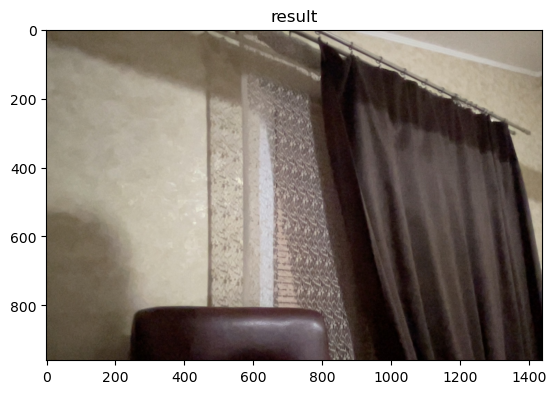

In [7]:
# img = cv2.imread('../imgs/recognition-test-2.jpg')
img = cv2.imread('../imgs/img_5.jpg')
print_image(img)

--> OpenCv
Execution time: 180.05990982055664 ms
[[409, 251, 493, 493], [1185, 307, 77, 77]]
2


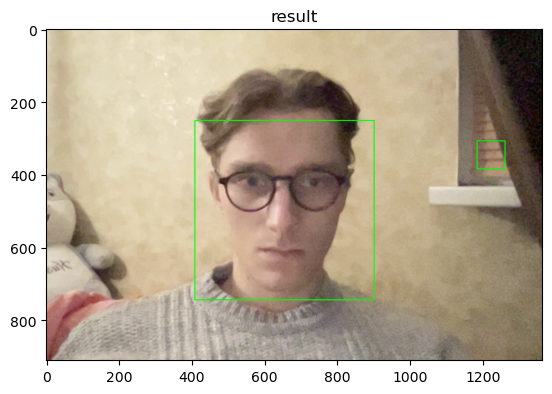

In [10]:
runDetector('OpenCv', detectFaceOpenCv)

--> Mtcnn
Execution time: 1217.296838760376 ms
[[451, 242, 370, 482]]
1


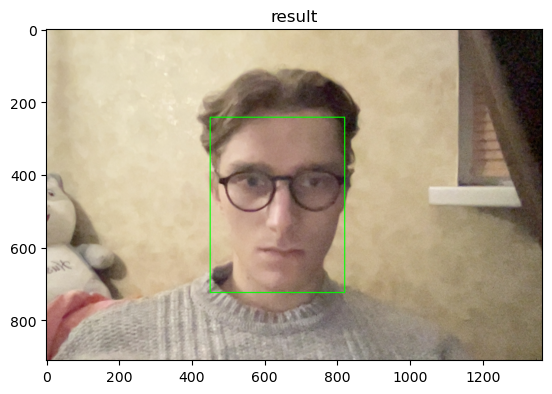

In [11]:
runDetector('Mtcnn', detectFaceMtcnn)

--> RetinaFace
Execution time: 6711.69900894165 ms
[]
0


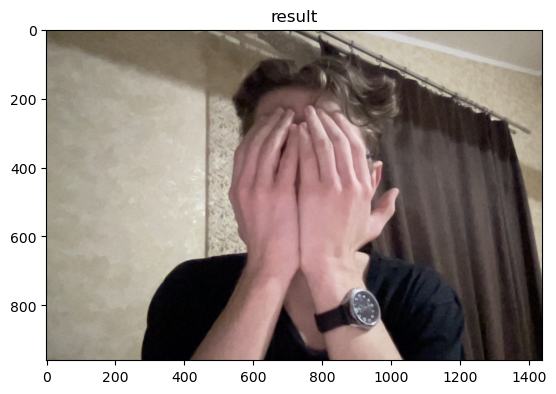

In [6]:
runDetector('RetinaFace', detectFaceRetinaFace)

--> mediapipe
Execution time: 6.333827972412109 ms
[]
0


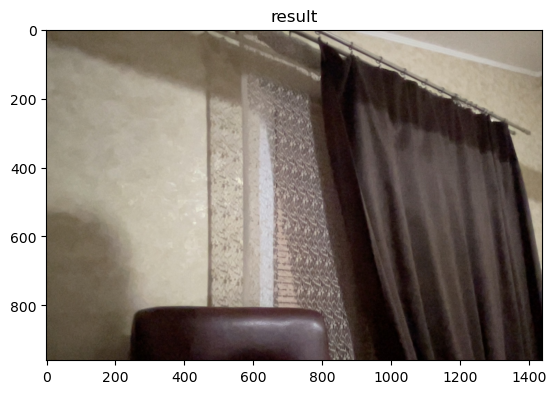

In [8]:
runDetector('mediapipe', detectFaceMediapipe)

In [12]:

try:
    res = cv2.imread('')
except:
    print('err')

[ WARN:0@926.150] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_506zufg7xt/croots/recipe/opencv-suite_1664548331847/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_(''): can't open/read file: check file path/integrity


In [11]:
res